In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import sklearn
import gensim
import spacy
import re
!python3 --version
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
import matplotlib
print(matplotlib.__version__)
print(gensim.__version__)

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import string
import pickle

Python 3.7.10
1.1.5
1.19.5
0.22.2.post1
3.2.2
3.6.0


In [3]:
# stop word: 機能語の除去
from nltk.corpus import stopwords
import nltk
from bs4 import BeautifulSoup
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
# StopWord の再定義
stop = set(stopwords.words("english"))

# 句読点の追加。string.punctuation = ['!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']
punctuation = list(string.punctuation)

# 手動で追加
org_stop = ["Subject"]

# stopwordsの定義更新
add_stop = punctuation# + org_stop
stop.update(add_stop)

In [5]:
# htmlの分割
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# []で囲まれた文章の削除（脚注、linkなど）
def remove_between_square_brackets(text):
    return re.sub('\[[^[]*\]', '', text)

def remove_between_round_brackets(text):
    return re.sub('\([^()]*\)', '', text)

# URLの削除
def remove_URLs(text):
    return re.sub(r'http\S+', '', text)

def replace_eq(text):
    return re.sub('\$[^$]+\=[^$]+\$', 'the equation ', text)

def replace_symbol(text):
    return re.sub('\$[^$]*\w\$', 'the symbol ', text)

def replace_symbol_plus(text):
    return re.sub('\{[^$]*\w\}', 'the symbol ', text)

def remove_newline(text):
    return re.sub('\\n', ' ', text)


# stopwordsの削除
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text)

def remove_puncts(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in punctuation:
            if i.strip().isalpha():
                final_text.append(i.strip())
    return " ".join(final_text).lower()

# 上記の関数をまとめて適用する関数を定義
def denoise_text(text):
    text = strip_html(text)
    text = remove_URLs(text)
    text = remove_between_square_brackets(text)
    text = remove_between_round_brackets(text)
    text = replace_eq(text)
    text = replace_symbol(text)
    text = replace_symbol_plus(text)
    text = remove_newline(text)
    #text = remove_stopwords(text)
    text = remove_puncts(text)
    return text

In [6]:
%cd "/content/drive/My Drive/word2vec"

/content/drive/My Drive/word2vec


In [7]:
# CSVデータの読み込み
df_CL = pd.read_csv("arxiv_cs.CL_abstract_100000.csv", header=None, names=['date', 'updatedate', 'abst'], parse_dates=['date', 'updatedate'])
df_AI = pd.read_csv("arxiv_cs.AI_abstract_100000.csv", header=None, names=['date', 'updatedate', 'abst'], parse_dates=['date', 'updatedate'])
df_FL = pd.read_csv("arxiv_cs.FL_abstract_100000.csv", header=None, names=['date', 'updatedate', 'abst'], parse_dates=['date', 'updatedate'])
df_PL = pd.read_csv("arxiv_cs.PL_abstract_100000.csv", header=None, names=['date', 'updatedate', 'abst'], parse_dates=['date', 'updatedate'])

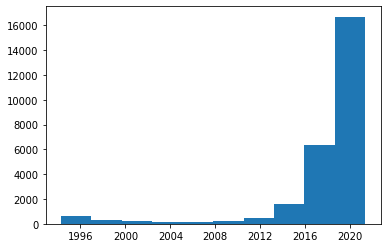

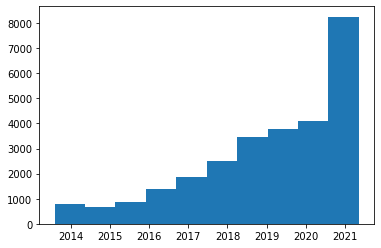

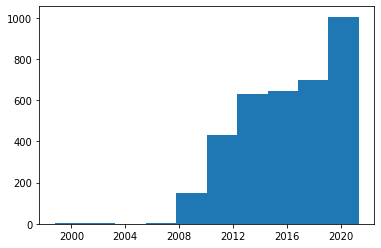

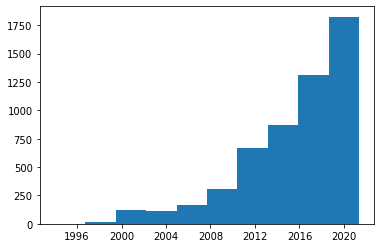

In [8]:
plt.hist(df_CL.date)
plt.show()
plt.hist(df_AI.date)
plt.show()
plt.hist(df_FL.date)
plt.show()
plt.hist(df_PL.date)
plt.show()

In [ ]:
# 年代を揃え、表記ゆれを削除して結合
with open('cs_abst_100000.txt', mode='w') as f:
    f.write(" ".join(
        df_CL[df_CL.date>df_AI.date.min()].abst.apply(denoise_text).tolist()
     + df_AI[df_AI.date>df_AI.date.min()].abst.apply(denoise_text).tolist()
     + df_FL[df_FL.date>df_AI.date.min()].abst.apply(denoise_text).tolist()
     + df_PL[df_PL.date>df_AI.date.min()].abst.apply(denoise_text).tolist()))

In [11]:
# FatsText 環境を構築
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!pip install .
%cd ..
#https://fasttext.cc/docs/en/python-module.html#model-object

/content/drive/My Drive/word2vec/fastText
Processing /content/drive/My Drive/word2vec/fastText
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3087661 sha256=66cdeffe664aca3f1e8301681030201b79c221a15ae7a8c7eee5e2506b1b813f
  Stored in directory: /tmp/pip-ephem-wheel-cache-7m0lgl4m/wheels/44/92/6e/b50b2d0eb702f67c83addc58f5b570827ffff274299c6cdd22
Successfully built fasttext
/content/drive/My Drive/word2vec


In [12]:
import fasttext

In [ ]:
# 学習してモデルを保存
model = fasttext.train_unsupervised('cs_abst_100000.txt')
model.save_model('cs_abst_100000.bin')

In [14]:
model = fasttext.load_model('cs_abst_100000.bin')

In [18]:
model.get_dimension(), len(model.words)

(100, 19242)

In [15]:
# 言語
languages = ["python", "c++", "julia", "java", "csharp", "ruby", "php", "haskell", "bash", "javascript", "rust", "scala", "fortran", "scheme",
              "prolog", "awk", "erlang", "elixir", "go", "kotlin", "lua", "ocaml", "objective-c", "swift", "perl", "typescript", "brainfuck", "cobol", "unlambda",
              "d", "r", "clojure", "crystal", "dart", "fsharp", "forth",
              "FORTRAN77", "go language", "basic", "pascal", "lisp",
              "piet", "befunge", "whitespace", "Ook!","lazyk","TeX", "LaTeX", "labview",
              "wenyan", "produire", "TTSneo", "Nadesiko",
              "html", "css", "SQL",
              "japanese", "english", "chinese"]
language_sentence = ["c language", "go language", "d language", "r language", "lazy k"]

In [19]:
# 単語→100次元ベクトルを作成
langs100d = np.array([model.get_word_vector(lang) for lang in languages])

In [22]:
from sklearn.decomposition import PCA

# 100次元→2次元の次元削減
pca = PCA(n_components=2)
langs2d = pca.fit_transform(langs100d)

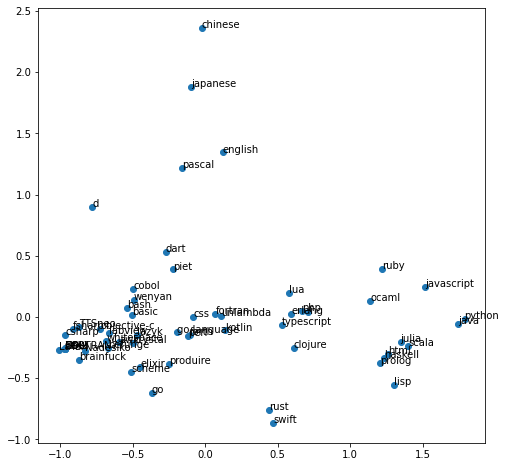

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(langs2d[:,0], langs2d[:,1])
for i,l in enumerate(languages):
    plt.annotate(l, (langs2d[:,0][i], langs2d[:,1][i]))

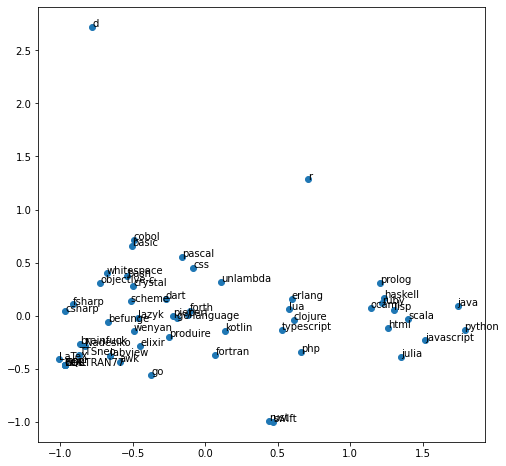

In [29]:
# 自然言語を除く
pca = PCA(n_components=2)
langs2d = pca.fit_transform(langs100d[:-3])

plt.figure(figsize=(8,8))
plt.scatter(langs2d[:,0], langs2d[:,1])
for i,l in enumerate(languages[:-3]):
    plt.annotate(l, (langs2d[:,0][i], langs2d[:,1][i]))

In [30]:
from sklearn.cluster import KMeans

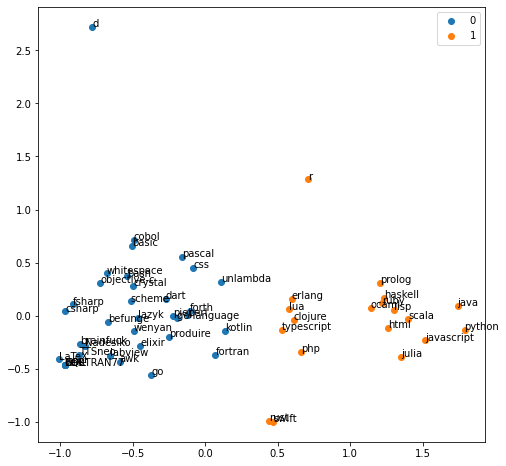

In [32]:
ncls = 2
kmeans = KMeans(n_clusters=ncls, random_state=0)
kmeans.fit(langs100d[:-3])
plt.figure(figsize=(8,8))
for cls in range(ncls):
  plt.scatter(langs2d[:,0][kmeans.labels_==cls], langs2d[:,1][kmeans.labels_==cls], label=str(cls))
for i,l in enumerate(languages[:-3]):
    plt.annotate(l, (langs2d[:,0][i], langs2d[:,1][i]))
plt.legend()

0 ['c++', 'csharp', 'bash', 'fortran', 'scheme', 'awk', 'elixir', 'go', 'kotlin', 'objective-c', 'perl', 'brainfuck', 'cobol', 'unlambda', 'd', 'crystal', 'dart', 'fsharp', 'forth', 'FORTRAN77', 'go language', 'basic', 'pascal', 'piet', 'befunge', 'whitespace', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'css', 'SQL']
1 ['python', 'julia', 'java', 'ruby', 'php', 'haskell', 'javascript', 'rust', 'scala', 'prolog', 'erlang', 'lua', 'ocaml', 'swift', 'typescript', 'r', 'clojure', 'lisp', 'html']


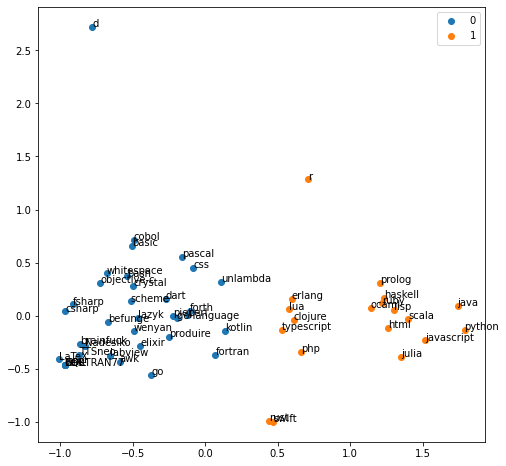

0 ['c++', 'csharp', 'bash', 'rust', 'fortran', 'scheme', 'awk', 'elixir', 'go', 'kotlin', 'objective-c', 'swift', 'perl', 'brainfuck', 'cobol', 'unlambda', 'crystal', 'dart', 'fsharp', 'forth', 'FORTRAN77', 'go language', 'basic', 'pascal', 'piet', 'befunge', 'whitespace', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'css', 'SQL']
1 ['python', 'julia', 'java', 'ruby', 'php', 'haskell', 'javascript', 'scala', 'prolog', 'erlang', 'lua', 'ocaml', 'typescript', 'r', 'clojure', 'lisp', 'html']
2 ['d']


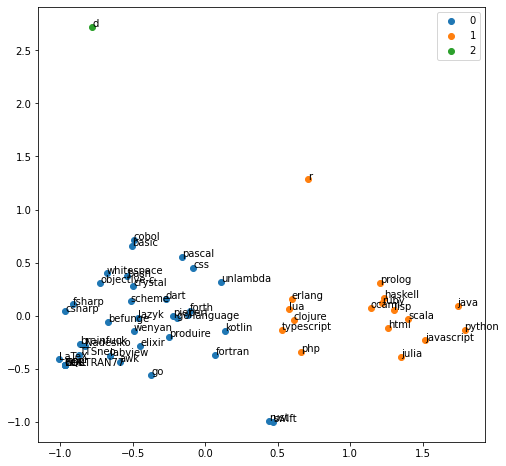

0 ['c++', 'csharp', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'fsharp', 'FORTRAN77', 'befunge', 'whitespace', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'wenyan', 'TTSneo', 'Nadesiko', 'SQL']
1 ['python', 'julia', 'java', 'ruby', 'haskell', 'javascript', 'scala', 'prolog', 'ocaml', 'lisp', 'html']
2 ['d']
3 ['php', 'bash', 'rust', 'fortran', 'erlang', 'go', 'kotlin', 'lua', 'swift', 'perl', 'typescript', 'cobol', 'unlambda', 'r', 'clojure', 'crystal', 'dart', 'forth', 'go language', 'basic', 'pascal', 'piet', 'produire', 'css']


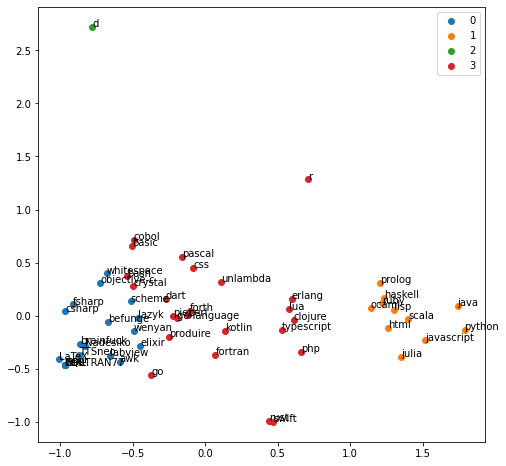

0 ['c++', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'FORTRAN77', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'TTSneo', 'Nadesiko', 'SQL']
1 ['ocaml']
2 ['d']
3 ['csharp', 'bash', 'rust', 'fortran', 'go', 'kotlin', 'perl', 'cobol', 'crystal', 'dart', 'fsharp', 'forth', 'go language', 'basic', 'pascal', 'piet', 'befunge', 'whitespace', 'wenyan', 'produire']
4 ['python', 'julia', 'java', 'ruby', 'php', 'haskell', 'javascript', 'scala', 'prolog', 'erlang', 'lua', 'swift', 'typescript', 'unlambda', 'r', 'clojure', 'lisp', 'html', 'css']


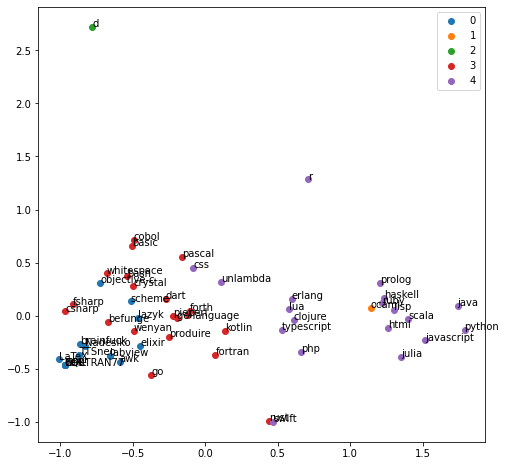

0 ['c++', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'FORTRAN77', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'TTSneo', 'Nadesiko', 'SQL']
1 ['ocaml']
2 ['d']
3 ['csharp', 'bash', 'rust', 'fortran', 'kotlin', 'perl', 'cobol', 'r', 'crystal', 'dart', 'fsharp', 'forth', 'go language', 'basic', 'pascal', 'piet', 'befunge', 'whitespace', 'wenyan', 'produire', 'css']
4 ['python', 'julia', 'java', 'ruby', 'php', 'haskell', 'javascript', 'scala', 'prolog', 'erlang', 'lua', 'swift', 'typescript', 'unlambda', 'clojure', 'lisp', 'html']
5 ['go']


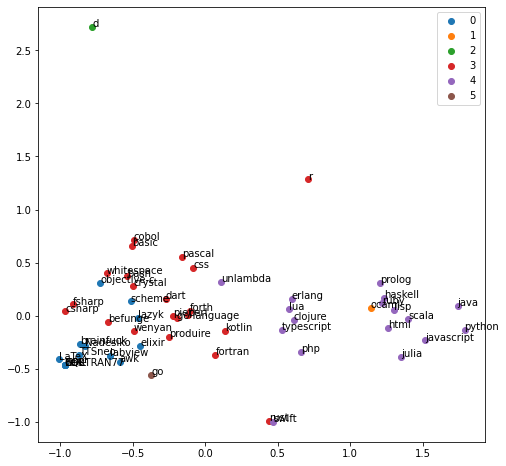

0 ['c++', 'csharp', 'awk', 'elixir', 'go', 'objective-c', 'brainfuck', 'unlambda', 'fsharp', 'FORTRAN77', 'go language', 'befunge', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'SQL']
1 ['python', 'julia', 'scala', 'ocaml']
2 ['haskell', 'prolog', 'lisp']
3 ['java', 'ruby', 'php', 'javascript', 'erlang', 'lua', 'swift', 'typescript', 'clojure', 'html']
4 ['scheme']
5 ['d']
6 ['bash', 'rust', 'fortran', 'kotlin', 'perl', 'cobol', 'r', 'crystal', 'dart', 'forth', 'basic', 'pascal', 'piet', 'whitespace', 'css']


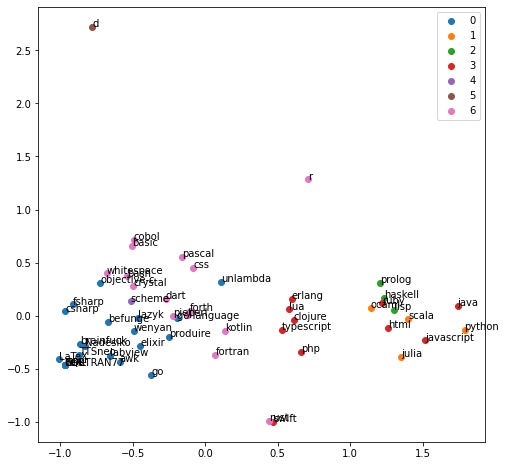

0 ['bash', 'fortran', 'scheme', 'perl', 'cobol', 'crystal', 'dart', 'forth', 'basic', 'pascal', 'piet', 'whitespace']
1 ['c++', 'csharp', 'awk', 'elixir', 'go', 'objective-c', 'brainfuck', 'fsharp', 'FORTRAN77', 'go language', 'befunge', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'SQL']
2 ['ruby', 'php', 'javascript', 'kotlin', 'lua', 'typescript', 'html']
3 ['d']
4 ['julia', 'haskell', 'rust', 'scala', 'erlang', 'ocaml', 'swift', 'unlambda', 'clojure', 'css']
5 ['r']
6 ['python', 'java']
7 ['prolog', 'lisp']


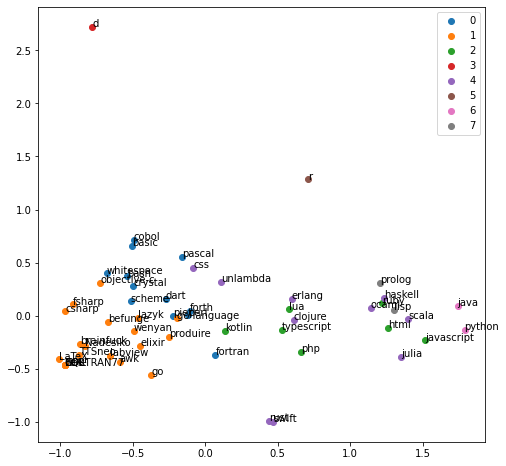

0 ['bash', 'scheme', 'erlang', 'kotlin', 'typescript', 'cobol', 'unlambda', 'd', 'crystal', 'basic', 'whitespace', 'css']
1 ['python', 'java', 'javascript', 'r']
2 ['rust']
3 ['c++', 'csharp', 'awk', 'elixir', 'objective-c', 'brainfuck', 'fsharp', 'FORTRAN77', 'go language', 'befunge', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'SQL']
4 ['julia', 'scala', 'ocaml', 'swift', 'clojure']
5 ['haskell', 'prolog', 'lisp']
6 ['ruby', 'php', 'lua', 'html']
7 ['fortran', 'go', 'perl', 'forth', 'piet']
8 ['dart', 'pascal']


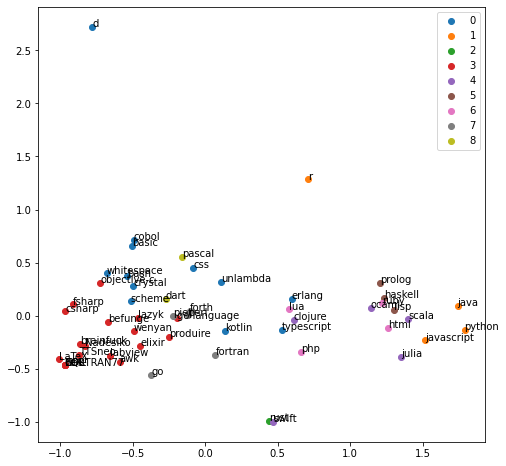

0 ['go', 'crystal', 'produire', 'css']
1 ['c++', 'csharp', 'awk', 'elixir', 'objective-c', 'brainfuck', 'dart', 'fsharp', 'FORTRAN77', 'go language', 'befunge', 'Ook!', 'lazyk', 'TeX', 'LaTeX', 'labview', 'wenyan', 'TTSneo', 'Nadesiko', 'SQL']
2 ['python', 'scala']
3 ['pascal']
4 ['julia', 'haskell', 'erlang', 'ocaml', 'swift', 'unlambda', 'clojure']
5 ['bash', 'scheme', 'cobol', 'r', 'basic', 'whitespace']
6 ['java', 'ruby', 'php', 'javascript', 'lua', 'typescript', 'html']
7 ['rust', 'fortran', 'kotlin', 'perl', 'forth', 'piet']
8 ['prolog', 'lisp']
9 ['d']


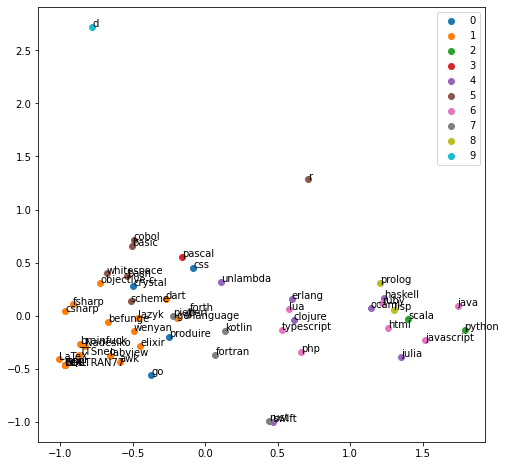

In [34]:
for ncls in range(2,11):
  kmeans = KMeans(n_clusters=ncls, random_state=0)
  kmeans.fit(langs100d[:-3])
  
  plt.figure(figsize=(8,8))
  for cls in range(ncls):
    plt.scatter(langs2d[:,0][kmeans.labels_==cls], langs2d[:,1][kmeans.labels_==cls], label=str(cls))
    print(cls, [lang for i,lang in enumerate(languages[:-3]) if kmeans.labels_[i]==cls])
  for i,l in enumerate(languages[:-3]):
      plt.annotate(l, (langs2d[:,0][i], langs2d[:,1][i]))
  plt.legend()
  plt.show()

In [35]:
langsents100d = [model.get_sentence_vector(lang) for lang in language_sentence]
langsents2d = pca.transform(langsents100d)

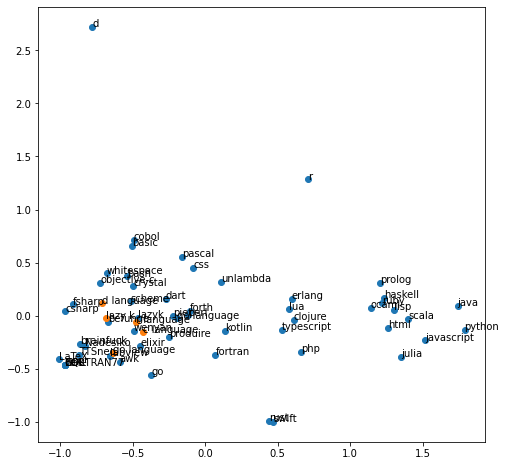

In [37]:
plt.figure(figsize=(8,8))
plt.scatter(langs2d[:,0], langs2d[:,1])
plt.scatter(langsents2d[:,0], langsents2d[:,1])
for i,l in enumerate(languages[:-3]):
    plt.annotate(l, (langs2d[:,0][i], langs2d[:,1][i]))
for i,l in enumerate(language_sentence):
    plt.annotate(l, (langsents2d[:,0][i], langsents2d[:,1][i]))

In [ ]:
for ncls in range(2,11):
  kmeans = KMeans(n_clusters=ncls, random_state=0)
  kmeans.fit(langs100d[:-3])
  
  plt.figure(figsize=(8,8))
  for cls in range(ncls):
    plt.scatter(langs2d[:,0][kmeans.labels_==cls], langs2d[:,1][kmeans.labels_==cls], label=str(cls))
    print(cls, [lang for i,lang in enumerate(languages[:-3]) if kmeans.labels_[i]==cls])
  for i,l in enumerate(languages[:-3]):
      plt.annotate(l, (langs2d[:,0][i], langs2d[:,1][i]))
  plt.legend()
  plt.show()

In [39]:
language_sentence

['c language', 'go language', 'd language', 'r language', 'lazy k']

In [45]:
l100 = np.concatenate(([v for v,l in zip(langs100d,languages) if l not in ["english", "japanese", "chinese", "r", "c", "d", "go", "lazyk"]], langsents100d))
l2 = np.concatenate(([v for v,l in zip(langs2d,languages) if l not in ["english", "japanese", "chinese", "r", "c", "d", "go", "lazyk"]], langsents2d))
langs = [l for l in languages if l not in ["english", "japanese", "chinese", "r", "c", "d", "go", "lazyk"]] + language_sentence

0 ['c++', 'csharp', 'bash', 'fortran', 'scheme', 'awk', 'elixir', 'kotlin', 'objective-c', 'perl', 'brainfuck', 'cobol', 'unlambda', 'crystal', 'dart', 'fsharp', 'forth', 'FORTRAN77', 'go language', 'basic', 'pascal', 'piet', 'befunge', 'whitespace', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'css', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
1 ['python', 'julia', 'java', 'ruby', 'php', 'haskell', 'javascript', 'rust', 'scala', 'prolog', 'erlang', 'lua', 'ocaml', 'swift', 'typescript', 'clojure', 'lisp', 'html']


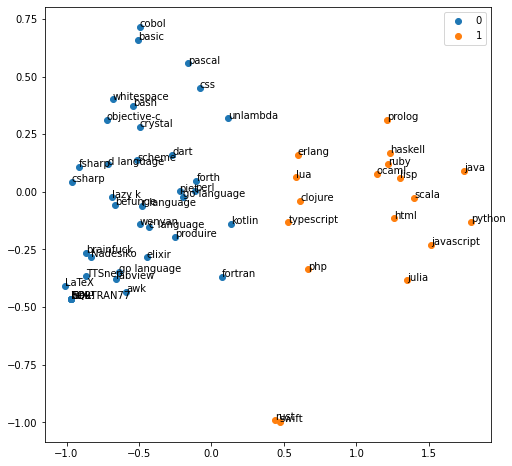

0 ['pascal']
1 ['python', 'julia', 'java', 'ruby', 'php', 'haskell', 'javascript', 'rust', 'scala', 'prolog', 'erlang', 'lua', 'ocaml', 'swift', 'typescript', 'clojure', 'lisp', 'html']
2 ['c++', 'csharp', 'bash', 'fortran', 'scheme', 'awk', 'elixir', 'kotlin', 'objective-c', 'perl', 'brainfuck', 'cobol', 'unlambda', 'crystal', 'dart', 'fsharp', 'forth', 'FORTRAN77', 'go language', 'basic', 'piet', 'befunge', 'whitespace', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'css', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']


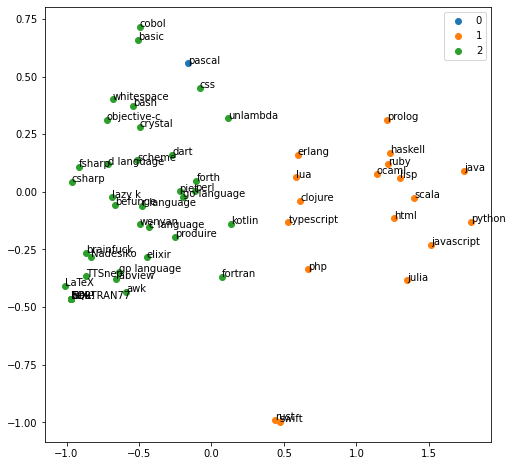

0 ['pascal']
1 ['bash', 'fortran', 'perl', 'cobol', 'crystal', 'forth', 'basic']
2 ['c++', 'csharp', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'dart', 'fsharp', 'FORTRAN77', 'go language', 'piet', 'befunge', 'whitespace', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
3 ['python', 'julia', 'java', 'ruby', 'php', 'haskell', 'javascript', 'rust', 'scala', 'prolog', 'erlang', 'kotlin', 'lua', 'ocaml', 'swift', 'typescript', 'unlambda', 'clojure', 'lisp', 'html', 'css']


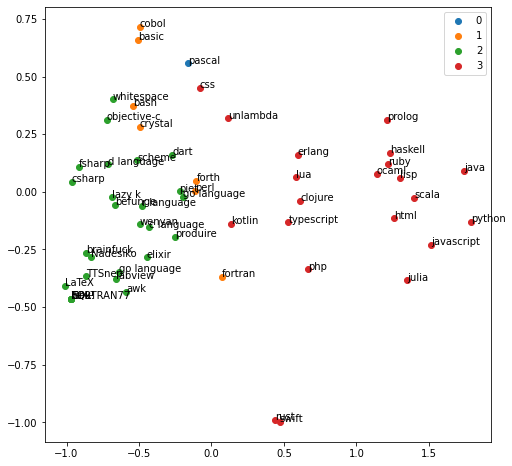

0 ['bash', 'rust', 'fortran', 'erlang', 'kotlin', 'perl', 'cobol', 'dart', 'forth', 'pascal', 'piet', 'whitespace']
1 ['ruby', 'php', 'lua', 'swift', 'typescript', 'html']
2 ['python', 'java', 'javascript']
3 ['c++', 'csharp', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'unlambda', 'crystal', 'fsharp', 'FORTRAN77', 'go language', 'basic', 'befunge', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'css', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
4 ['julia', 'haskell', 'scala', 'prolog', 'ocaml', 'clojure', 'lisp']


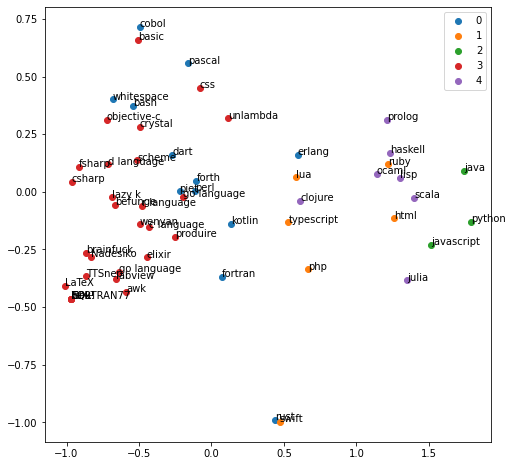

0 ['bash', 'rust', 'fortran', 'erlang', 'kotlin', 'perl', 'cobol', 'dart', 'forth', 'pascal', 'piet', 'whitespace']
1 ['ruby', 'php', 'lua', 'swift', 'typescript', 'html']
2 ['python', 'java', 'javascript']
3 ['c++', 'csharp', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'unlambda', 'crystal', 'fsharp', 'FORTRAN77', 'go language', 'basic', 'befunge', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'css', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
4 ['julia', 'scala', 'ocaml', 'clojure']
5 ['haskell', 'prolog', 'lisp']


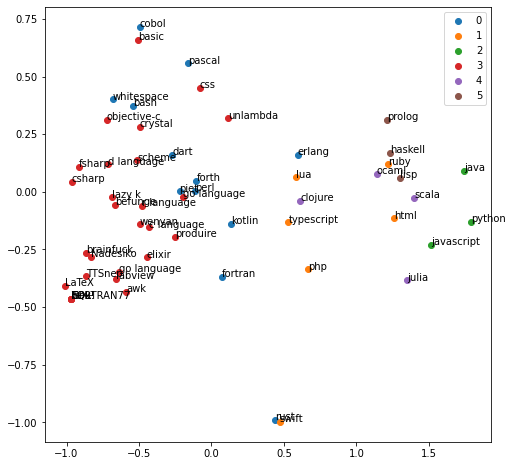

0 ['bash', 'rust', 'fortran', 'erlang', 'kotlin', 'perl', 'cobol', 'dart', 'forth', 'pascal', 'piet', 'whitespace']
1 ['ruby', 'php', 'lua', 'swift', 'typescript', 'html']
2 ['python', 'java', 'javascript']
3 ['c++', 'csharp', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'unlambda', 'crystal', 'fsharp', 'FORTRAN77', 'go language', 'basic', 'befunge', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
4 ['julia', 'scala', 'ocaml', 'clojure']
5 ['haskell', 'prolog', 'lisp']
6 ['css']


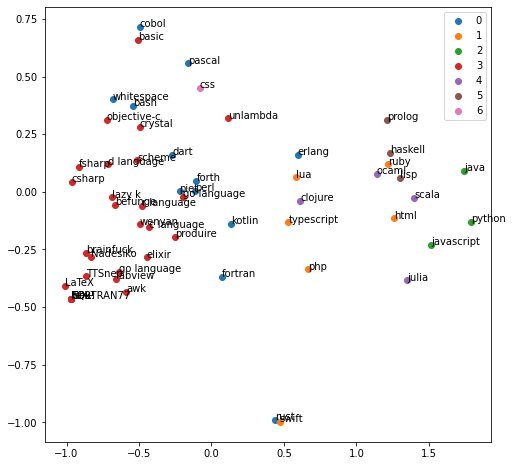

0 ['c++', 'awk', 'elixir', 'FORTRAN77', 'Ook!', 'TeX', 'LaTeX', 'labview', 'TTSneo', 'Nadesiko', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
1 ['haskell', 'prolog']
2 ['java', 'ruby', 'php', 'javascript', 'lua', 'typescript', 'html']
3 ['julia', 'rust', 'scala', 'erlang', 'ocaml', 'swift', 'clojure', 'lisp']
4 ['forth']
5 ['pascal']
6 ['python']
7 ['csharp', 'bash', 'fortran', 'scheme', 'kotlin', 'objective-c', 'perl', 'brainfuck', 'cobol', 'unlambda', 'crystal', 'dart', 'fsharp', 'go language', 'basic', 'piet', 'befunge', 'whitespace', 'wenyan', 'produire', 'css']


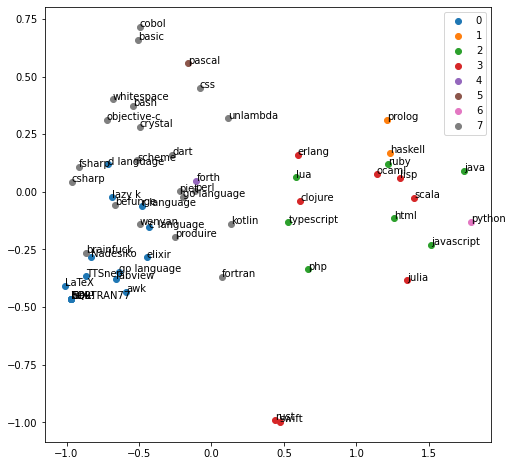

0 ['csharp', 'fsharp']
1 ['c++', 'bash', 'scheme', 'awk', 'elixir', 'objective-c', 'brainfuck', 'cobol', 'unlambda', 'crystal', 'FORTRAN77', 'go language', 'basic', 'piet', 'befunge', 'whitespace', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
2 ['python', 'java']
3 ['julia', 'scala', 'ocaml', 'clojure']
4 ['rust', 'fortran', 'erlang', 'kotlin', 'perl', 'forth']
5 ['ruby', 'php', 'javascript', 'lua', 'swift', 'typescript', 'html']
6 ['css']
7 ['haskell', 'prolog', 'lisp']
8 ['dart', 'pascal']


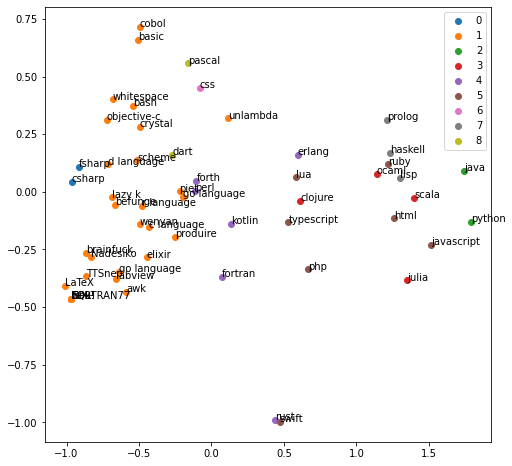

0 ['pascal']
1 ['bash', 'cobol', 'basic']
2 ['c++', 'csharp', 'awk', 'elixir', 'objective-c', 'brainfuck', 'crystal', 'dart', 'fsharp', 'FORTRAN77', 'go language', 'befunge', 'whitespace', 'Ook!', 'TeX', 'LaTeX', 'labview', 'wenyan', 'produire', 'TTSneo', 'Nadesiko', 'SQL', 'c language', 'go language', 'd language', 'r language', 'lazy k']
3 ['unlambda', 'clojure', 'css']
4 ['php', 'rust', 'fortran', 'erlang', 'kotlin', 'lua', 'swift', 'perl', 'forth', 'piet']
5 ['java', 'ruby', 'javascript', 'typescript']
6 ['scheme']
7 ['python', 'julia', 'haskell', 'scala', 'ocaml']
8 ['html']
9 ['prolog', 'lisp']


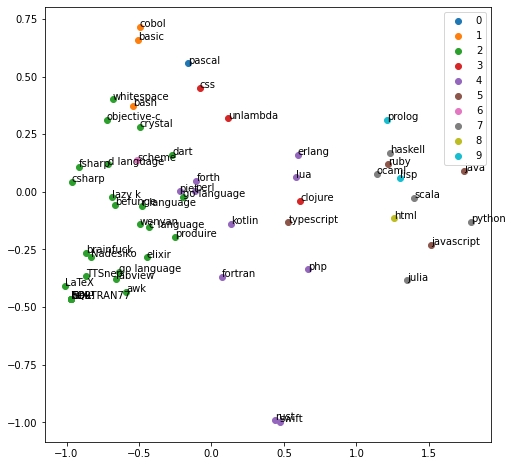

In [47]:
for ncls in range(2, 11):
  kmeans = KMeans(n_clusters=ncls, random_state=0)
  kmeans.fit(l100)
  
  plt.figure(figsize=(8,8))
  for cls in range(ncls):
    plt.scatter(l2[:,0][kmeans.labels_==cls], l2[:,1][kmeans.labels_==cls], label=str(cls))
    print(cls, [lang for i,lang in enumerate(langs) if kmeans.labels_[i]==cls])
  for i,l in enumerate(langs):
      plt.annotate(l, (l2[:,0][i], l2[:,1][i]))
  plt.legend()
  plt.show()

In [48]:
ncls=10
kmeans = KMeans(n_clusters=ncls, random_state=0)
kmeans.fit(l100)
for cls in range(ncls):
  print(cls)
  for lang in [lang for i,lang in enumerate(langs) if kmeans.labels_[i]==cls]:
    print(lang, lang in model.words)

0
pascal True
1
bash False
cobol False
basic True
2
c++ False
csharp False
awk False
elixir False
objective-c False
brainfuck False
crystal True
dart True
fsharp False
FORTRAN77 False
go language False
befunge False
whitespace False
Ook! False
TeX False
LaTeX False
labview False
wenyan False
produire False
TTSneo False
Nadesiko False
SQL False
c language False
go language False
d language False
r language False
lazy k False
3
unlambda False
clojure True
css True
4
php True
rust True
fortran True
erlang True
kotlin True
lua True
swift True
perl False
forth True
piet False
5
java True
ruby True
javascript True
typescript True
6
scheme True
7
python True
julia True
haskell True
scala True
ocaml True
8
html True
9
prolog True
lisp True
